# Loan Default Prediction - Imperial College London

## 1. Import Library

In [6]:
import numpy as np
import pandas as pd

import os
import random
from tqdm import tqdm

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn.model_selection import KFold
from sklearn.ensemble import GradientBoostingRegressor

from lightgbm import LGBMClassifier

import warnings
warnings.filterwarnings('ignore')

### 1-1. Seed Fixed

In [7]:
def seed_everything(seed: int = 42):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)

seed_everything(42)

## 2. Load Dataset

In [8]:
train = pd.read_csv('train_v2.csv.zip', low_memory=False)
train.head()

,id,f1,f2,f3,f4,f5,f6,f7,f8,f9,...,f770,f771,f772,f773,f774,f775,f776,f777,f778,loss
0,1,126,10,0.686842,1100,3,13699,7201.0,4949.0,126.75,...,5,2.14,-1.54,1.18,0.1833,0.7873,1,0,5,0
1,2,121,10,0.782776,1100,3,84645,240.0,1625.0,123.52,...,6,0.54,-0.24,0.13,0.1926,-0.6787,1,0,5,0
2,3,126,10,0.500080,1100,3,83607,1800.0,1527.0,127.76,...,13,2.89,-1.73,1.04,0.2521,0.7258,1,0,5,0
3,4,134,10,0.439874,1100,3,82642,7542.0,1730.0,132.94,...,4,1.29,-0.89,0.66,0.2498,0.7119,1,0,5,0
4,5,109,9,0.502749,2900,4,79124,89.0,491.0,122.72,...,26,6.11,-3.82,2.51,0.2282,-0.5399,0,0,5,0


In [9]:
test = pd.read_csv('test_v2.csv.zip', low_memory=False)
test.head()

,id,f1,f2,f3,f4,f5,f6,f7,f8,f9,...,f769,f770,f771,f772,f773,f774,f775,f776,f777,f778
0,105472,147,6,0.487058,1100,17.0,75506,964.0,12686.0,152.63,...,-8.71,19,3.30,-9.37,0.50,0.0539,-1.0733,0,1,1079
1,105473,156,6,0.728518,5400,3.0,79754,1455.0,4803.0,153.95,...,-13.26,24,9.53,-7.55,6.22,0.3030,0.6087,0,1,36
2,105474,132,9,0.898133,2200,16.0,113,5735.0,2387.0,130.61,...,-4.99,9,3.25,-2.33,1.69,0.2317,0.4184,0,0,393
3,105475,128,7,0.038411,1300,4.0,3793,4689.0,3469.0,120.50,...,-16.83,11,0.26,-5.31,0.78,0.2826,-0.7711,0,0,394
4,105476,119,10,0.443620,1300,16.0,13026,2788.0,7438.0,127.00,...,-20.00,10,13.55,-0.61,0.01,0.1815,-1.0843,0,0,23


### 2-1. Data Description

In [10]:
print(f'Train shape: {train.shape}, Test shape: {test.shape}')

Train shape: (105471, 771), Test shape: (210944, 770)


In [11]:
def data_describe(df, title):
    print(f'====================== {title} Data Describe ======================')
    print(f'Row: {df.shape[0]}, Column: {df.shape[1]}')
    columns = df.columns
    data_type = []

    for col in columns:
        data_type.append(df[col].dtype)

    n_uniq = df.nunique()
    n_miss = df.isna().sum()

    names = list(zip(columns, data_type, n_uniq, n_miss))
    variable_desc = pd.DataFrame(names, columns=['Column', 'Dtype', 'Unique levels', 'Missing Count'])
    print(variable_desc)

In [12]:
data_describe(train, 'train')

====================== train Data Describe ======================
Row: 105471, Column: 771
    Column    Dtype  Unique levels  Missing Count
0       id    int64         105471              0
1       f1    int64             74              0
2       f2    int64             10              0
3       f3  float64         105209              0
4       f4    int64             61              0
..     ...      ...            ...            ...
766   f775  float64          23740           1525
767   f776    int64              2              0
768   f777    int64              2              0
769   f778    int64             64              0
770   loss    int64             89              0

[771 rows x 4 columns]


In [13]:
data_describe(test, 'test')

====================== test Data Describe ======================
Row: 210944, Column: 770
    Column    Dtype  Unique levels  Missing Count
0       id    int64         210944              0
1       f1    int64             73              0
2       f2    int64             11              0
3       f3  float64         105208              0
4       f4    int64             61              0
..     ...      ...            ...            ...
765   f774  float64           3516           2066
766   f775  float64          23475           2960
767   f776    int64              2              0
768   f777    int64              2              0
769   f778    int64             63              0

[770 rows x 4 columns]


In [14]:
num_columns = train.select_dtypes(include=np.number).columns.tolist()
print('수치형 변수\n', num_columns)
cat_columns = train.select_dtypes(exclude=np.number).columns.tolist()
print('범주형 변수\n', cat_columns)

수치형 변수
 ['id', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10', 'f13', 'f14', 'f15', 'f16', 'f17', 'f18', 'f19', 'f20', 'f21', 'f22', 'f23', 'f24', 'f25', 'f26', 'f27', 'f28', 'f29', 'f30', 'f31', 'f32', 'f33', 'f34', 'f35', 'f36', 'f37', 'f38', 'f39', 'f40', 'f41', 'f42', 'f43', 'f44', 'f45', 'f46', 'f47', 'f48', 'f49', 'f50', 'f51', 'f52', 'f53', 'f54', 'f55', 'f56', 'f57', 'f58', 'f59', 'f60', 'f61', 'f62', 'f63', 'f64', 'f65', 'f66', 'f67', 'f68', 'f69', 'f70', 'f71', 'f72', 'f73', 'f74', 'f75', 'f76', 'f77', 'f78', 'f79', 'f80', 'f81', 'f82', 'f83', 'f84', 'f85', 'f86', 'f87', 'f88', 'f89', 'f90', 'f91', 'f92', 'f93', 'f94', 'f95', 'f96', 'f97', 'f98', 'f99', 'f100', 'f101', 'f102', 'f103', 'f104', 'f105', 'f106', 'f107', 'f108', 'f109', 'f110', 'f111', 'f112', 'f113', 'f114', 'f115', 'f116', 'f117', 'f118', 'f119', 'f120', 'f121', 'f122', 'f123', 'f124', 'f125', 'f126', 'f127', 'f128', 'f129', 'f130', 'f131', 'f132', 'f133', 'f134', 'f135', 'f136', 'f139', 'f140', 'f1

### 2-2. 결측치(Missing Value) 확인
- 결측치 비율 확인

In [15]:
nan_check = pd.DataFrame(train.isnull().sum(), columns=['result'])
print(nan_check[nan_check['result']>0].index.tolist())

['f7', 'f8', 'f14', 'f15', 'f17', 'f18', 'f19', 'f20', 'f21', 'f22', 'f23', 'f26', 'f31', 'f32', 'f39', 'f40', 'f41', 'f42', 'f43', 'f44', 'f45', 'f46', 'f47', 'f48', 'f49', 'f50', 'f51', 'f52', 'f53', 'f54', 'f55', 'f56', 'f57', 'f58', 'f59', 'f60', 'f61', 'f62', 'f63', 'f64', 'f65', 'f66', 'f72', 'f75', 'f76', 'f77', 'f78', 'f79', 'f80', 'f81', 'f82', 'f83', 'f84', 'f85', 'f86', 'f87', 'f88', 'f89', 'f90', 'f91', 'f92', 'f93', 'f94', 'f95', 'f96', 'f97', 'f98', 'f99', 'f100', 'f101', 'f102', 'f103', 'f104', 'f105', 'f106', 'f107', 'f108', 'f109', 'f110', 'f111', 'f112', 'f113', 'f114', 'f115', 'f116', 'f117', 'f118', 'f119', 'f120', 'f121', 'f122', 'f123', 'f124', 'f125', 'f126', 'f127', 'f128', 'f129', 'f130', 'f131', 'f132', 'f133', 'f134', 'f135', 'f136', 'f137', 'f138', 'f139', 'f140', 'f141', 'f142', 'f143', 'f144', 'f145', 'f146', 'f147', 'f148', 'f149', 'f150', 'f151', 'f152', 'f153', 'f154', 'f155', 'f156', 'f157', 'f158', 'f159', 'f160', 'f161', 'f162', 'f163', 'f164', 'f165

In [16]:
nan_percentage_check = pd.DataFrame(train.isnull().sum()/len(train)*100, columns=['result'])
nan_percentage_check[nan_percentage_check['result']>0]

,result
f7,0.172559
f8,0.095761
f14,0.094813
f15,0.045510
f17,0.150752
...,...
f762,0.149804
f763,1.744555
f765,0.000948
f774,1.008808


In [17]:
train.dtypes.value_counts()

float64    652
int64       99
object      19
uint64       1
dtype: int64

In [18]:
test.dtypes.value_counts()

float64    653
int64       96
object      19
uint64       2
dtype: int64

- train과 test의 데이터 타입이 다른 경우가 있음.
 따라서 train과 test의 데이터 타입이 다른 경우 train의 데이터 타입을 반영함

## 3. EDA

### 3-1. Target Distribution
- loss는 0~100사이의 정수이며 0이 전체 데이터의 90% 이상을 차지하고 있음

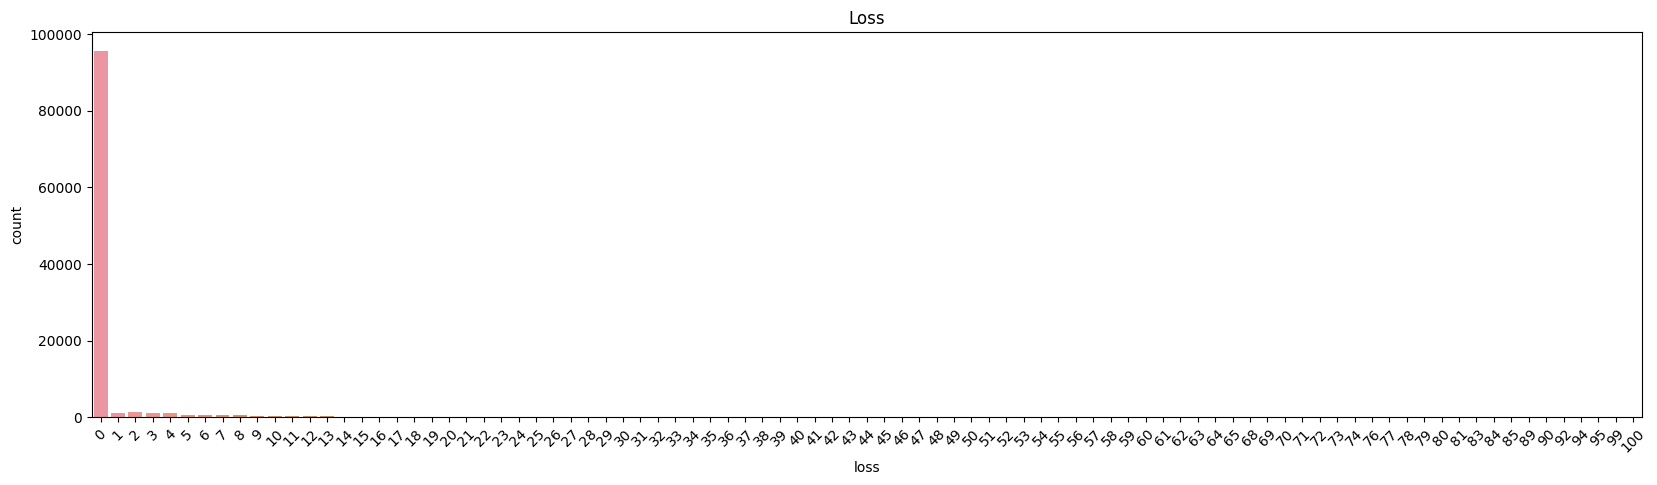

In [19]:
plt.figure(figsize=(20, 5))
ax = sns.countplot(x='loss', data=train, order = sorted(train['loss'].unique()))
plt.title('Loss')
plt.xticks(rotation=45)
plt.show()

## 4. Data Preprocessing

### 4-1. 데이터 타입 변환

In [20]:
cols = test.columns.tolist()

for x in tqdm(cols):
    if train[x].dtype not in ['float64']:
        train[x] = train[x].astype(float)
    if test[x].dtype != train[x].dtype: # test의 데이터 타입과 train의 데이터 타입이 다른 경우
        test[x] = test[x].astype(train[x].dtype)

100%|██████████| 770/770 [00:06<00:00, 117.86it/s]


In [21]:
train.dtypes.value_counts()

float64    770
int64        1
dtype: int64

In [22]:
test.dtypes.value_counts()

float64    770
dtype: int64

### 4-2. 파생 피처 생성
- diff_f274_f527 파생 피처
- diff_f527_f528 파생 피처

In [23]:
train['diff_f274_f527'] = train['f274'] - train['f527']
test['diff_f274_f527'] = test['f274'] - test['f527']

train['diff_f527_f528'] = train['f527'] - train['f528']
test['diff_f527_f528'] = test['f527'] - test['f528']

In [24]:
train['default'] = train['loss'].apply(lambda x: 1 if x>0 else 0)

In [25]:
train_x = train.drop(['id', 'loss', 'default'], axis=1)
train_y = train['default']
train_loss = train['loss']

test_x = test.drop(['id'], axis=1)

In [26]:
X_train_columns = train_x.columns
X_test_columns = test_x.columns

### 4-3. 결측치 처리
- `Imputer` 누락된 값 처리
- 아래의 코드는 Null값을 중앙값(median)으로 채움

In [27]:
print(f'Train 결측치 확인\n{train_x.isnull().sum()}')

Train 결측치 확인
f1                  0
f2                  0
f3                  0
f4                  0
f5                  0
                 ... 
f776                0
f777                0
f778                0
diff_f274_f527    101
diff_f527_f528    101
Length: 771, dtype: int64


In [28]:
print(f'Test 결측치 확인\n{test_x.isnull().sum()}')

Test 결측치 확인
f1                  0
f2                  0
f3                  0
f4                  0
f5                864
                 ... 
f776                0
f777                0
f778                0
diff_f274_f527    228
diff_f527_f528    228
Length: 771, dtype: int64


In [29]:
# 중앙값을 사용한 결측값 처리
imputer_median  = SimpleImputer(strategy='median')

imputer_median.fit(train_x)
train_x = imputer_median.transform(train_x)
test_x = imputer_median.transform(test_x)

### 4-4. 데이터 스케일링
- `StandardScaler`: 각 특성을 평균 0($\mu=0$), 분산 1($\sigma^2=1$)인 표준 정규분포($N\sim(\mu, \sigma^2)$)로 변경함
- `Z-Score` 구하는 공식
$$z=\frac{data\;point - mean}{standard\;deviation}=\frac{x-\mu}{\sigma}$$

In [30]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

scaler.fit(train_x)
train_x = scaler.transform(train_x)
test_x = scaler.transform(test_x)

In [31]:
X_train_df = pd.DataFrame(train_x, columns=X_train_columns)
X_test_df = pd.DataFrame(test_x, columns=X_test_columns)

### 4-5. 필요 없는 Feature 제거
- 다중공선성을 해결하기 위해 상관계수가 0.99이상인 feature를 삭제함. 상관계수가 높은 feature를 제거하여 과적합을 방지함

In [32]:
corr_matrix = X_train_df.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

to_drop = [column for column in upper.columns if any(upper[column] > 0.99)]
print(f'삭제할 컬럼명: {to_drop}\n삭제할 컬럼의 개수: {len(to_drop)}')

X_train_df = X_train_df.drop(columns = to_drop, axis=1)
X_test_df = X_test_df.drop(columns = to_drop, axis=1)

삭제할 컬럼명: ['f10', 'f40', 'f42', 'f50', 'f52', 'f56', 'f58', 'f62', 'f74', 'f79', 'f86', 'f87', 'f88', 'f96', 'f97', 'f98', 'f106', 'f107', 'f108', 'f115', 'f116', 'f117', 'f118', 'f125', 'f126', 'f127', 'f128', 'f138', 'f141', 'f146', 'f155', 'f156', 'f157', 'f164', 'f165', 'f166', 'f167', 'f174', 'f175', 'f176', 'f177', 'f184', 'f185', 'f186', 'f187', 'f194', 'f195', 'f196', 'f197', 'f206', 'f207', 'f215', 'f225', 'f226', 'f227', 'f235', 'f236', 'f237', 'f245', 'f246', 'f247', 'f254', 'f255', 'f256', 'f257', 'f264', 'f265', 'f266', 'f267', 'f277', 'f280', 'f294', 'f295', 'f296', 'f302', 'f303', 'f304', 'f310', 'f311', 'f312', 'f318', 'f319', 'f320', 'f326', 'f327', 'f328', 'f338', 'f343', 'f345', 'f352', 'f354', 'f356', 'f360', 'f362', 'f369', 'f371', 'f373', 'f377', 'f379', 'f387', 'f389', 'f400', 'f401', 'f408', 'f409', 'f410', 'f411', 'f414', 'f415', 'f417', 'f424', 'f427', 'f435', 'f437', 'f439', 'f443', 'f445', 'f446', 'f447', 'f452', 'f453', 'f454', 'f457', 'f460', 'f464', 'f467'

In [33]:
X_train_df = pd.concat([X_train_df, train_y, train_loss], axis=1)
X_train_df.head()

,f1,f2,f3,f4,f5,f6,f7,f8,f9,f13,...,f769,f774,f775,f776,f777,f778,diff_f274_f527,diff_f527_f528,default,loss
0,-0.584240,1.036411,0.650303,-1.126684,-0.845362,-0.961256,1.661562,1.111105,-0.564589,-1.185340,...,0.583035,-0.692820,0.742929,1.491055,-0.690486,-0.5731,-0.016661,0.145031,0,0
1,-0.923790,1.036411,0.982541,-1.126684,-0.845362,1.027310,-1.074144,-0.358426,-0.798230,-1.185340,...,0.764778,-0.565817,-0.676527,1.491055,-0.690486,-0.5731,0.006063,0.232187,0,0
2,-0.584240,1.036411,0.003511,-1.126684,-0.845362,0.998215,-0.461057,-0.401752,-0.491531,-1.185340,...,0.372378,0.246723,0.683381,1.491055,-0.690486,-0.5731,-0.021827,0.212265,0,0
3,-0.040961,1.036411,-0.204993,-1.126684,-0.845362,0.971167,1.795576,-0.312006,-0.116837,-1.185340,...,0.696624,0.215313,0.669922,1.491055,-0.690486,-0.5731,-0.001089,0.212651,0,0
4,-1.738708,0.445229,0.012754,0.158109,-0.651228,0.872560,-1.133488,-0.859765,-0.856098,-1.457894,...,-0.241005,-0.079659,-0.542134,-0.670666,-0.690486,-0.5731,0.003777,0.235470,0,0


## 5. Model
- 평가지표: 평균절대오차(MAE)
$$MAE=\frac{1}{n}\sum_{i=1}^{n}|y_i-\hat{y}_i|$$
  - MAE: 손실함수
  - $y_i$: $i$번째 학습 데이터의 정답(실제 loss)
  - $\hat{y}_i$: $i$번째 학습 데이터로 예측한 값(예측된 loss)

### 5-1. default 예측: LGBMClassifier 모델

In [34]:
def default_model(train, test, vars, seed):
    cv = KFold(n_splits=5, shuffle=True, random_state=seed)
    train['default_pred'] = 0.0
    for train_idx, val_idx in cv.split(train):
        X_train, X_val = train[vars].loc[train_idx], train[vars].loc[val_idx]
        y_train, y_val = train['default'].loc[train_idx], train['default'].loc[val_idx]

        model = LGBMClassifier()
        model.fit(X_train, y_train)
        train.loc[val_idx, 'default_pred'] = model.predict_proba(X_val)[:,1] # default_pred 컬럼 추가

    model.fit(train[vars], train['default'])
    test['default_pred'] = model.predict_proba(test)[:,1]

    result = {'AUC': roc_auc_score(train['default'], train['default_pred']),
              'F1': f1_score(X_train_df['default'], X_train_df['default_pred'].apply(lambda x: 1 if x>0.5 else 0))} # cut-off에 따라 f1-score가 달라질 수 있음(현재는 0.5로 고정)

    print(f"AUC Score: {np.round(result['AUC'], 5)}")
    print(f"F1 Score: {np.round(result['F1'], 5)}")

    return result

In [35]:
default_model_result = default_model(X_train_df, X_test_df, X_test_df.columns.tolist(), 42)

AUC Score: 0.99807
F1 Score: 0.93729


In [36]:
X_train_df.head()

,f1,f2,f3,f4,f5,f6,f7,f8,f9,f13,...,f774,f775,f776,f777,f778,diff_f274_f527,diff_f527_f528,default,loss,default_pred
0,-0.584240,1.036411,0.650303,-1.126684,-0.845362,-0.961256,1.661562,1.111105,-0.564589,-1.185340,...,-0.692820,0.742929,1.491055,-0.690486,-0.5731,-0.016661,0.145031,0,0,0.000594
1,-0.923790,1.036411,0.982541,-1.126684,-0.845362,1.027310,-1.074144,-0.358426,-0.798230,-1.185340,...,-0.565817,-0.676527,1.491055,-0.690486,-0.5731,0.006063,0.232187,0,0,0.000062
2,-0.584240,1.036411,0.003511,-1.126684,-0.845362,0.998215,-0.461057,-0.401752,-0.491531,-1.185340,...,0.246723,0.683381,1.491055,-0.690486,-0.5731,-0.021827,0.212265,0,0,0.000073
3,-0.040961,1.036411,-0.204993,-1.126684,-0.845362,0.971167,1.795576,-0.312006,-0.116837,-1.185340,...,0.215313,0.669922,1.491055,-0.690486,-0.5731,-0.001089,0.212651,0,0,0.000030
4,-1.738708,0.445229,0.012754,0.158109,-0.651228,0.872560,-1.133488,-0.859765,-0.856098,-1.457894,...,-0.079659,-0.542134,-0.670666,-0.690486,-0.5731,0.003777,0.235470,0,0,0.000032


In [37]:
X_test_df.head()

,f1,f2,f3,f4,f5,f6,f7,f8,f9,f13,...,f764,f769,f774,f775,f776,f777,f778,diff_f274_f527,diff_f527_f528,default_pred
0,0.841867,-1.328316,-0.041586,-1.126684,1.872511,0.771150,-0.789609,4.531613,1.307434,0.177428,...,0.0,0.007859,-2.459923,-1.058599,-0.670666,1.448255,3.027391,610.411256,52.338952,0.000009
1,1.453056,-1.328316,0.794635,1.942543,-0.845362,0.890218,-0.596644,1.046559,1.402916,0.177428,...,0.0,-0.461988,0.941820,0.569999,-0.670666,1.448255,-0.469175,0.111558,0.082234,0.000127
2,-0.176781,0.445229,1.382045,-0.341533,1.678377,-1.342062,1.085417,-0.021548,-0.285377,0.449982,...,0.0,0.391998,-0.031863,0.385741,-0.670666,-0.690486,0.727636,0.023124,0.207784,0.000006
3,-0.448421,-0.737134,-1.595337,-0.983929,-0.651228,-1.238914,0.674334,0.456801,-1.016681,-0.640233,...,0.0,-0.830637,0.663235,-0.765994,-0.670666,-0.690486,0.730988,-52.458850,-11.745027,0.985014
4,-1.059609,1.036411,-0.192020,-0.983929,1.678377,-0.980120,-0.072768,2.211486,-0.546505,0.177428,...,0.0,-1.157982,-0.717401,-1.069250,-0.670666,-0.690486,-0.512757,-891.711612,1455.556085,0.000070


### 5-2. loss 예측: GradientBoostingRegressor 모델
- `n_estimators`: 트리의 수(반복 수)
- `max_depth`: 트리의 깊이(노드 수)
- `learning_rate`: 학습률
- `max_features`: 노드 분할에 사용되는 특성의 수

In [38]:
def check_cutoff(loss, pred_loss, pred_default):
    best = 99
    tmp = np.copy(pred_loss)
    for cutoff in np.arange(0.01, 0.99, 0.01):
        tmp[pred_default < cutoff] = 0
        if mean_absolute_error(tmp, loss) < best:
            best = mean_absolute_error(tmp, loss)
            bestcut = cutoff
    return {'mae': best, 'cut_off': bestcut}

In [39]:
def loss_model(model, train, test, vars, seed):
    cv = KFold(n_splits=5, shuffle=True, random_state=seed)
    train['loss_pred'] = 0.0
    for train_idx, val_idx in cv.split(train):
        tmp = train.loc[train_idx]
        tmp = tmp[tmp['default'] > 0]
        model.fit(tmp[vars], np.log(tmp['loss']))
        train.loc[val_idx, 'loss_pred'] = np.exp(model.predict(train[vars].loc[val_idx])) # loss_pred 컬럼 추가

    tmp = train[train['default'] > 0]
    model.fit(tmp[vars], np.log(tmp['loss']))
    test['loss_pred'] = np.exp(model.predict(test[vars]))

    result = check_cutoff(train['loss'], train['loss_pred'], train['default_pred']) # cut-off에 따라 f1-score가 달라질 수 있음(현재는 0.5로 고정)

    print(f"MAE: {result['mae']}")

    return result

In [40]:
vars = sorted(list(set(X_test_df.columns.tolist()) - set(['default_pred'])))
loss_model_result = loss_model(GradientBoostingRegressor(n_estimators=1000, max_depth=4, learning_rate=0.05, max_features='sqrt'), X_train_df, X_test_df, vars, 42)
print(loss_model_result)

MAE: 0.44687756345028856
{'mae': 0.44687756345028856, 'cut_off': 0.55}


In [41]:
pred = np.copy(X_test_df['loss_pred'])
pred[X_test_df['default_pred'] < loss_model_result['cut_off']] = 0.0

In [42]:
X_test_df['loss'] = pred

## 6. Submission

In [43]:
submission = pd.read_csv('sampleSubmission.csv')
submission.head()

,id,loss
0,105472,0
1,105473,0
2,105474,0
3,105475,0
4,105476,0


In [44]:
submission['loss'] = X_test_df['loss']
submission.to_csv('submission.csv', index=False)